# Adaptive Cruise Control

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.8.12 (default, Oct 12 2021, 13:49:34) \n[GCC 7.5.0]'

In [3]:
import refine_cbfs
from cbf_opt import ControlAffineDynamics, ControlAffineCBF, ControlAffineASIF
import matplotlib.pyplot as plt
import hj_reachability as hj
import jax.numpy as jnp
import numpy as np
import seaborn as sns

## Setup Problem (dynamics, environment and CBF)

Dynamics of the Adaptive Cruise Control problem (control affine), in the format of `cbf_opt`

`ACC_JNP_Dynamics` is required for usage with `hj_reachability` module

In [4]:
class ACCDynamics(ControlAffineDynamics):
    STATES = ['P', 'V', 'dP']
    CONTROLS = ['ACC']
    def __init__(self, params, **kwargs):
        params['n_dims'] = 3
        params['control_dims'] = 1  # TODO: How to do this correctly?
        self.mass = params["mass"]
        self.g = params["g"]
        self.f0 = params["f0"]
        self.f1 = params["f1"]
        self.f2 = params["f2"]
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[..., 1] + self.f2 * x[..., 1] ** 2
        self.v0 = params["v0"]
        super().__init__(params, **kwargs)

    def state_jacobian(self, state, control, time=0.):
        J = np.repeat(np.zeros_like(state)[..., None], self.n_dims, axis=-1)
        J[..., 0, 1] = 1
        J[..., 1, 1] = -1 / self.mass * (self.f1 + 2 * self.f2 * state[..., 1])
        J[..., 2, 1] = -1 
        return J
        
    def open_loop_dynamics(self, state, time=0.):
        f = np.zeros_like(state)
        f[..., 0] = state[..., 1]
        f[..., 1] = -1 / self.mass * self.rolling_resistance(state)
        f[..., 2] = self.v0 - state[..., 1]
        return f

    def control_matrix(self, state, time=0.):
        B = np.repeat(np.zeros_like(state)[..., None], self.control_dims, axis=-1)
        B[..., 1, 0] = 1 / self.mass 
        return B


class ACCJNPDynamics(ACCDynamics):
    def __init__(self, params, **kwargs):
        super().__init__(params, **kwargs)
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[1] + self.f2 * x[1] ** 2

    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([state[1], -1 / self.mass * self.rolling_resistance(state), self.v0 - state[1]])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 1 / self.mass, 0]), axis=-1)

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(3), axis=-1)

Setting up the Dynamics with specific parameter instantiation

In [5]:
params = dict()
params["dt"] = 0.01
params["g"] = 9.81
params['v0'] = 14  # lead vehicle velocity
params['f0'] = 0.1  # friction coefficient
params['f1'] = 5  # friction coefficient
params['f2'] = 0.25  # friction coefficient
params['mass'] = 1650  # vehicle mass

acc = ACCDynamics(params)
acc_jnp = ACCJNPDynamics(params)

## Initial Control Barrier Function
Below is a candidate CBF (safe, but overly conservative) for the problem. This is the optimal CBF when neglecting friction (but it does account for limited actuation).

In [6]:
class ACCCBF(ControlAffineCBF):
    def __init__(self, dynamics, params, **kwargs):
        self.Th = params["Th"]
        self.cd = params["cd"]
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=None):
        return state[..., 2] - self.Th * state[..., 1] - (state[..., 1] - self.dynamics.v0) ** 2 / (2 * self.cd * self.dynamics.g)

    def vf_dt_partial(self, state, time=None):
        return 0.0
    
    def _grad_vf(self, state, time=None):
        dvf_dx = np.zeros_like(state)
        dvf_dx[..., 1] = - self.Th  - (state[..., 1] - self.dynamics.v0) / (self.cd * self.dynamics.g)
        dvf_dx[..., 2] = 1.0
        return dvf_dx

Setting up the CBF with specific parameter instantiation

In [7]:
cbf_params = dict()
cbf_params["cd"] = 0.3
cbf_params["Th"] = 1.8
acc_cbf = ACCCBF(acc, cbf_params)

Setting maximal and minimal control effort

In [8]:
umax = np.array([cbf_params['cd'] * params['mass'] * params['g']])
umin = -umax

### Environment

In [9]:
dyn_reachability = refine_cbfs.HJControlAffineDynamics(acc_jnp, control_space=hj.sets.Box(jnp.array(umin), jnp.array(umax)))

low_bound = jnp.array([0., 10., 0.])
high_bound = jnp.array([1e3, 40., 100.])
nbr_pts = (51, 101, 101)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(low_bound, high_bound), nbr_pts)

In [10]:
obstacle = grid.states[..., 2] - acc_cbf.Th * grid.states[..., 1]

## Refining the CBF using Dynamic Programming

In [11]:
acc_tabular_cbf = refine_cbfs.TabularControlAffineCBF(acc, dict(), grid=grid)
acc_tabular_cbf.tabularize_cbf(acc_cbf)

In [12]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("medium",
                                                  value_postprocessor=backwards_reachable_tube(obstacle))
init_value = obstacle

In [13]:
time = 0.
target_time = -20.0
times = jnp.linspace(time, target_time, 101)
target_values = hj.solve(solver_settings, dyn_reachability, grid, times, init_value)

100%|##########| 20.0000/20.0 [01:57<00:00,  5.86s/sim_s]


In [14]:
refined_cbf = refine_cbfs.TabularControlAffineCBF(acc, grid=grid)
refined_cbf.vf_table = np.array(target_values[-1])

## Running an experiment (Same as the Paper)

In [15]:
x0 = np.array([[0, 25, 90], [0, 28, 99]])
n_sims_per_start = 1
t_sim = 20

In [16]:
from experiment_wrapper import RolloutTrajectory, TimeSeriesExperiment, StateSpaceExperiment

### Setting up the nominal controller

We simply tune a proporitional controller for the nominal controller

In [17]:
desired_vel = 24
feedback_gain = 1000
nominal_policy = lambda x, t: np.atleast_1d(np.clip(-feedback_gain * (x[..., 1] - desired_vel), umin, umax))

### Setting up the safety filter

In [18]:
alpha = lambda x: 5 * x

acc_asif = ControlAffineASIF(acc, acc_cbf, alpha=alpha, nominal_policy=nominal_policy)
acc_asif_ws = ControlAffineASIF(acc, refined_cbf, alpha=alpha, nominal_policy=nominal_policy)

### Rollout different CBFs / nominal controller

In [19]:
experiment = RolloutTrajectory('acc_example', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

In [20]:
results_df = experiment.run(acc, {'nominal': nominal_policy, 'Analytical': acc_asif, 'Refined': acc_asif_ws})

Controller rollout: 100%|██████████| 2000/2000 [02:56<00:00, 11.31it/s]


### Visualizing the results

In [21]:
ts_experiment = TimeSeriesExperiment('acc_example', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)
ss_experiment = StateSpaceExperiment('acc_example', x_indices=[1, 2], start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

[('Rollout (time series)', <Figure size 720x1440 with 5 Axes>)]

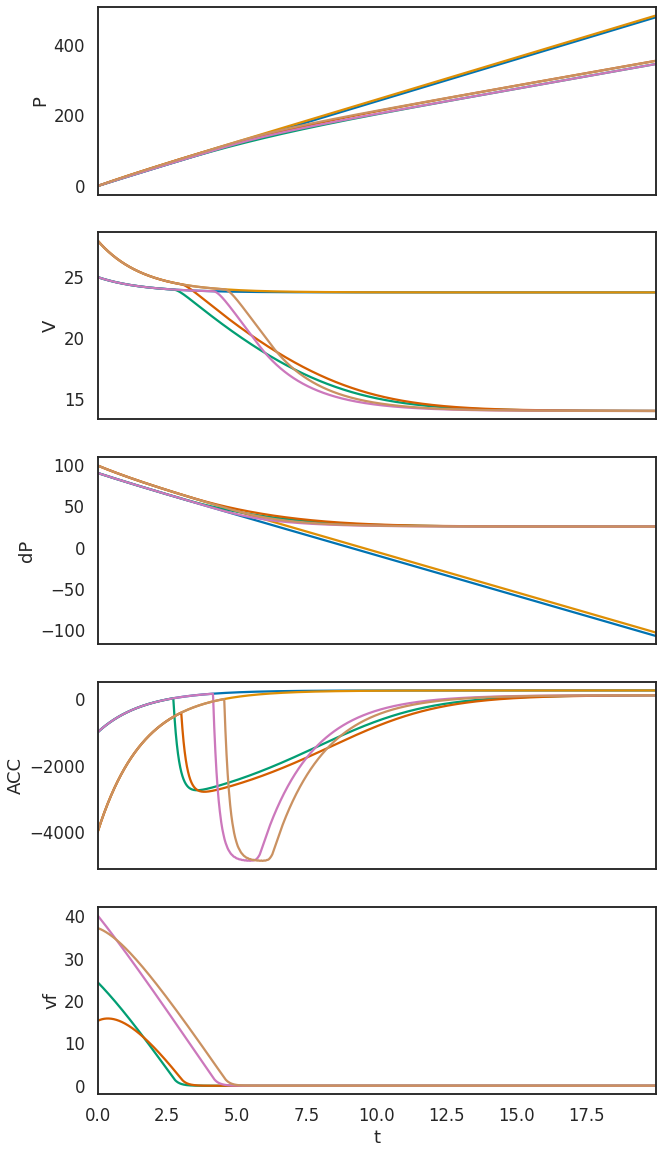

In [22]:
ts_experiment.plot(acc, results_df, extra_measurements=['vf'])

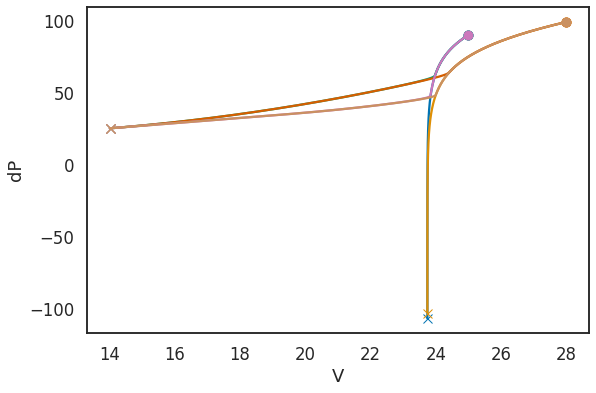

In [23]:
fig_handle = ss_experiment.plot(acc, results_df);

# Visualizations for paper + demo + videos

In [30]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '28',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.animation as anim

### Safe set visualization

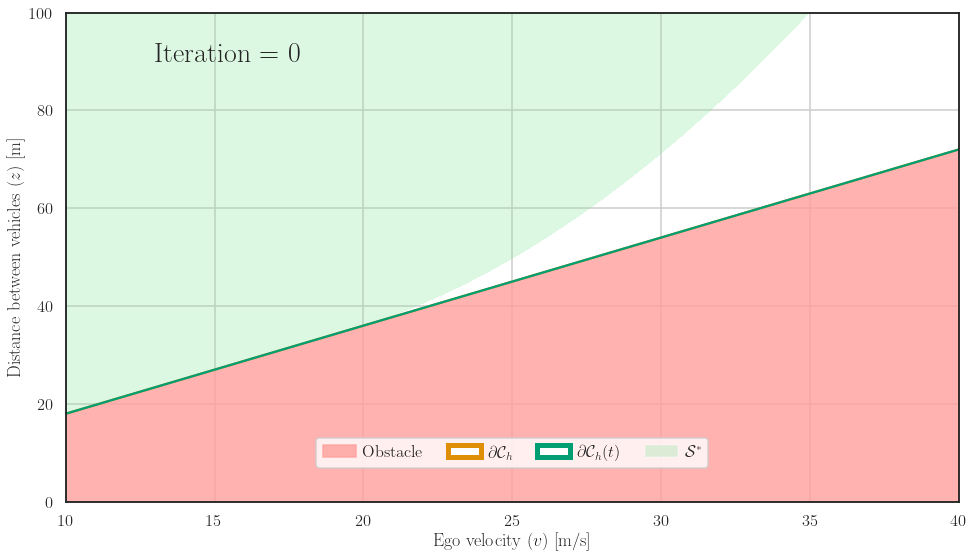

In [26]:
def render_frame(i, colorbar=False):
    global cont
    for c in cont.collections:
        c.remove()
    timestamp.set_text("Iteration = {}".format(i))
    cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[i][0].T, levels=[0], colors=gen_colors[2])

value_function = target_values
filename="acc/vf_time.mp4"
proxy = [] 

fig, ax = plt.subplots(figsize=(16, 9))
blue_colors = sns.color_palette("PuBuGn", 5).as_hex()
gen_colors = sns.color_palette("colorblind", 9).as_hex()
alt_colors = sns.color_palette("pastel", 9).as_hex()

cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], obstacle[0].T, levels=[-100, 0], colors=alt_colors[3], alpha=0.8)
proxy += [plt.Rectangle((0,0),1,1, fc=alt_colors[3], ec=alt_colors[3], alpha=0.8) for pc in cs.collections]

cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[-1][0].T, levels=[0, 200], colors=alt_colors[2], alpha=0.3)


cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[0][0].T, levels=[0], colors=gen_colors[1])
# proxy += [plt.Rectangle((0,0),1,1,ec = 'b', fc='white') 
#         for pc in cs.collections]

proxy += [plt.Rectangle((0,0),1,1,ec = gen_colors[1], fc='white', lw=5)
        for pc in cont.collections]

timestamp = ax.text(0.1, 0.9, "", transform=ax.transAxes)

cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[0][0].T, levels=[0], colors=gen_colors[2])
proxy += [plt.Rectangle((0,0),1,1,ec = gen_colors[2], fc='white', lw=5)
        for pc in cont.collections]
# cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[-1][0].T, levels=[0], colors='orange')
# proxy += [plt.Rectangle((0,0),1,1,ec = 'orange', fc='white')
#         for pc in cs.collections]
ax.grid()

proxy += [plt.Rectangle((0,0),1,1,fc = alt_colors[2], ec='white', alpha=0.3)
        for pc in cs.collections]

ax.legend(proxy, ["Obstacle", "$\partial \mathcal{C}_h$", "$\partial \mathcal{C}_h(t)$", "$\mathcal{S}^*$"], loc='center', bbox_to_anchor=(0.5, 0.1), ncol=4, columnspacing=1.5, handletextpad=0.4)

ax.set_ylabel("Distance between vehicles ($z$) [m]")
ax.set_xlabel("Ego velocity ($v$) [m/s]")


# ax.set_title("Ames 2016", fontsize=24)
# fig.suptitle("Adaptive Cruise Control")
render_frame(0, False)
animation = anim.FuncAnimation(fig, render_frame, value_function.shape[0] * 6 // 20, interval=100)
# animation.save(filename, writer='ffmpeg')

### Online: Safety filter visualization

In [32]:
x0 = np.array([0, 25, 90])
experiment_paper = RolloutTrajectory('acc_example', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

In [39]:
paper_results = experiment_paper.run(acc, {'nominal': nominal_policy, 'Analytical': acc_asif, 'Refined': acc_asif_ws})

Controller rollout: 100%|██████████| 2000/2000 [01:23<00:00, 24.10it/s]


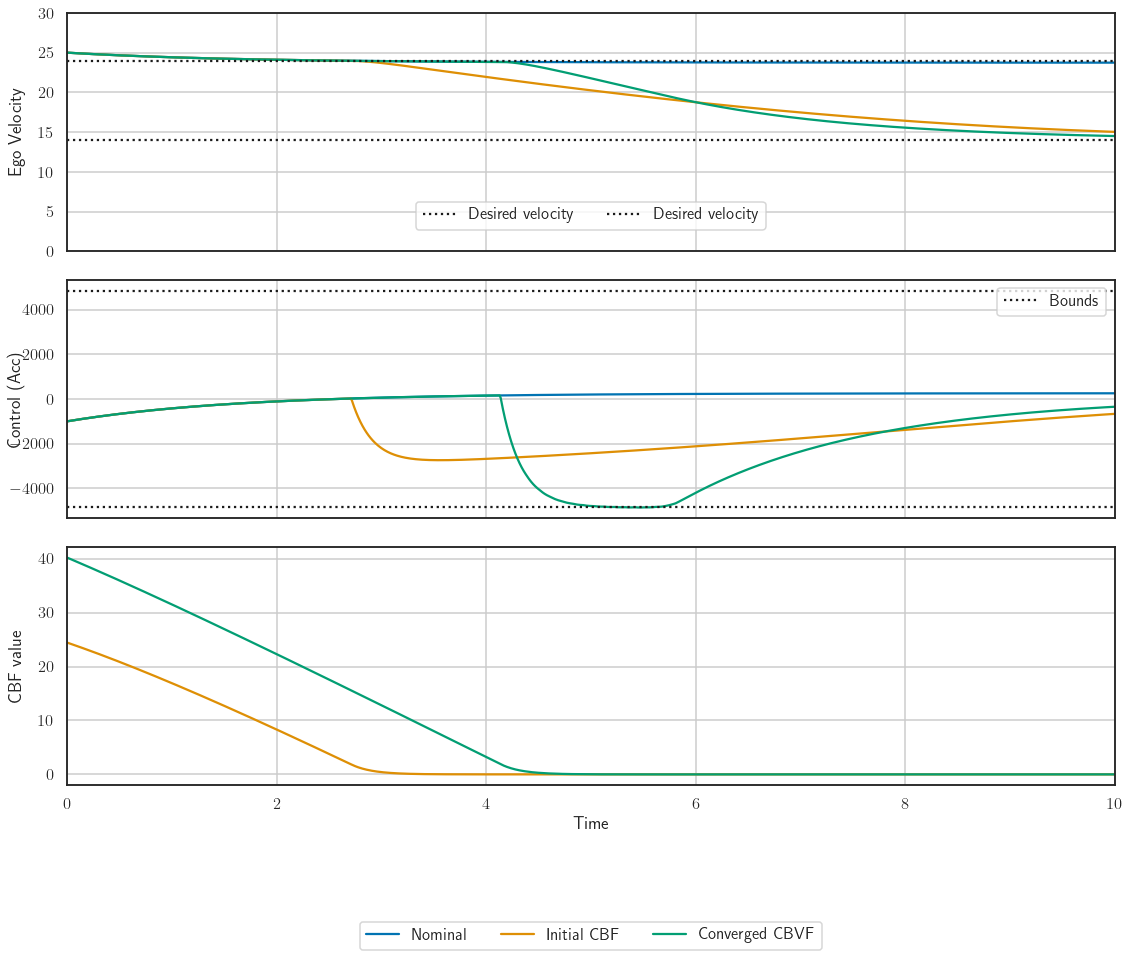

In [40]:
ts_experiment = TimeSeriesExperiment('acc_example', x_indices=[1], start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(16, 12))
fig_handle = ts_experiment.plot(acc, paper_results, extra_measurements=['vf'], axs=axs)
axs[0].set_ylabel("Ego Velocity")
ts = axs[0].lines[0]._x
axs[0].plot(ts, desired_vel * np.ones_like(ts), ':k', label='Desired velocity')
axs[0].plot(ts, params["v0"] * np.ones_like(ts), ':k', label='Desired velocity')
axs[0].set_ylim(0, 30)
axs[0].legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 0.15))
leg = axs[1].legend(["Nominal", "Initial CBF", "Converged CBVF"], ncol=3, loc='center', bbox_to_anchor=(0.5, -1.75))
axs[1].plot(ts, np.ones_like(ts) * umax, ':k', label='Bounds')
axs[1].plot(ts, np.ones_like(ts) * umin, ':k', label='__nolegend__')
axs[1].legend()
axs[1].set_ylabel("Control (Acc)")

axs[2].set_ylabel("CBF value")
axs[2].set_xlabel("Time")

for ax in axs:
    ax.grid()
    # axi.set_xlabel("Time")
    # axi.set_ylabel("Value")
    ax.yaxis.set_label_coords(-0.04, 0.5)
    ax.set_xlim([ts[0], 10])
    
fig.tight_layout()
fig.subplots_adjust(wspace=-0.05)
axs[1].add_artist(leg)
# fig.savefig("acc/acc_highway_asif.pdf", bbox_inches='tight')